In [1]:
import numpy as np
from datetime import datetime
import tensorflow as tf
import os

from tensorflow.python.platform import app
from tensorflow.python.platform import flags



# How often to record tensorboard summaries.
SUMMARY_INTERVAL = 40

# How often to run a batch through the validation model.
VAL_INTERVAL = 200

# How often to save a model checkpoint
SAVE_INTERVAL = 400

# tf record data location:
DATA_DIR = '/home/xca64/vml4/dataset/ucf101/ucf101_imgs'

# local output directory
OUT_DIR = '/cs/vml4/xca64/robot_data/result'

# summary output dir
SUM_DIR = '/cs/vml4/xca64/robot_data/summaries'

FLAGS = flags.FLAGS

flags.DEFINE_string('data_dir', DATA_DIR, 'directory containing data.')
flags.DEFINE_string('dataset_name', 'ucf', 'dataset used')
flags.DEFINE_string('output_dir', OUT_DIR, 'directory for model checkpoints.')
flags.DEFINE_string('gif_dir', '/cs/vml4/xca64/robot_data/gif/' , 'directory gif result')
flags.DEFINE_integer('gif_nums', 5 , 'number of gif files to save')
flags.DEFINE_string('event_log_dir',SUM_DIR, 'directory for writing summary.')
flags.DEFINE_integer('num_iterations', 100000, 'number of training iterations.')
flags.DEFINE_string('pretrained_model', '' ,
                    'filepath of a pretrained model to initialize from.')

flags.DEFINE_integer('sequence_length', 10,
                     'sequence length, including context frames.')
flags.DEFINE_integer('context_frames', 2, '# of frames before predictions.')
flags.DEFINE_integer('use_state', 1,
                     'Whether or not to give the state+action to the model')

flags.DEFINE_string('model', 'prednet',
                    'model architecture to use - prediction, prednet')

flags.DEFINE_string('optimizer', 'ADAM',
                    'model architecture to use - prediction, prednet')

flags.DEFINE_integer('num_masks', 10,
                     'number of masks, usually 1 for DNA, 10 for CDNA, STN.')
flags.DEFINE_float('schedsamp_k', 900.0,
                   'The k hyperparameter for scheduled sampling,'
                   '-1 for no scheduled sampling.')
flags.DEFINE_float('train_val_split', 0.95,
                   'The percentage of files to use for the training set,'
                   ' vs. the validation set.')

flags.DEFINE_float('gpu_memory_fraction', 1.0,
                   'gpu percentage')

flags.DEFINE_integer('batch_size', 32, 'batch size for training')
flags.DEFINE_float('learning_rate', 0.001,
                   'the base learning rate of the generator')

#####################
# Fine-Tuning Flags #
#####################

flags.DEFINE_string(
    'checkpoint_path', '/home/xca64/vml4/resnet/model/resnet_v1_50.ckpt',
    'The path to a checkpoint from which to fine-tune.')

flags.DEFINE_string(
    'checkpoint_exclude_scopes', 'resnet_v1_50/logits,predictions',
    'Comma-separated list of scopes of variables to exclude when restoring '
    'from a checkpoint.')

flags.DEFINE_string(
    'trainable_scopes', None,
    'Comma-separated list of scopes to filter the set of variables to train.'
    'By default, None would train all the variables.')

flags.DEFINE_boolean(
    'ignore_missing_vars', True,
    'When restoring a checkpoint would ignore missing variables.')



In [2]:
import sys
sys.path.append('/home/xca64/vml4/github/video_prediction')
%load_ext autoreload
%autoreload 2
from data.ucf101_img_input import build_tfrecord_input
from data.ucf101_img_input import build_tfrecord_input_val
from data.ucf101_img_input import get_image_paths_and_labels

In [ ]:
images, labels = build_tfrecord_input()

In [3]:
images, labels = build_tfrecord_input_val(training=False)

## Start to run resnet

In [ ]:
from tensorflow.python.ops import control_flow_ops
slim = tf.contrib.slim


In [ ]:
labels = slim.one_hot_encoding(
          tf.string_to_number(labels, out_type=tf.int32), 101)

In [ ]:
global_step = tf.Variable(0, trainable=False)

In [ ]:
from tensorflow.contrib.slim.nets import resnet_v1

In [ ]:
# inputs has shape [batch, 224, 224, 3]
with slim.arg_scope(resnet_v1.resnet_arg_scope()):
  net, end_points = resnet_v1.resnet_v1_50(images, 101)

In [ ]:
init_from_checkpoint = _get_init_fn()

In [ ]:
cross_entropy = tf.losses.softmax_cross_entropy(
    labels,tf.squeeze(net))

In [ ]:
train_op = train(cross_entropy, global_step, FLAGS.optimizer, FLAGS.learning_rate, 0.9999, _get_variables_to_train())

In [5]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
coord = tf.train.Coordinator()
tf.train.start_queue_runners(coord=coord, sess=sess)

[<Thread(Thread-4, started daemon 140671880353536)>,
 <Thread(Thread-5, started daemon 140671871960832)>,
 <Thread(Thread-6, started daemon 140671863568128)>,
 <Thread(Thread-7, started daemon 140671855175424)>,
 <Thread(Thread-8, started daemon 140671846782720)>,
 <Thread(Thread-9, started daemon 140671829788416)>,
 <Thread(Thread-10, started daemon 140671821395712)>,
 <Thread(Thread-11, started daemon 140671813003008)>,
 <Thread(Thread-12, started daemon 140671804610304)>,
 <Thread(Thread-13, started daemon 140671796217600)>,
 <Thread(Thread-14, started daemon 140671787824896)>,
 <Thread(Thread-15, started daemon 140671775397632)>,
 <Thread(Thread-16, started daemon 140671767004928)>,
 <Thread(Thread-17, started daemon 140671758612224)>,
 <Thread(Thread-18, started daemon 140671750219520)>,
 <Thread(Thread-19, started daemon 140671741826816)>,
 <Thread(Thread-20, started daemon 140671733434112)>,
 <Thread(Thread-21, started daemon 140671386121984)>,
 <Thread(Thread-22, started daemon

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

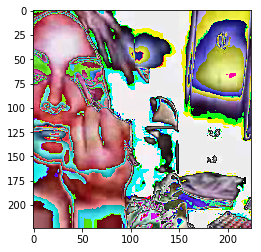

In [20]:
imgplot = plt.imshow(img[1])

In [ ]:
a = np.arange(6).reshape((3, 2))
b = a.reshape(-1)
print a, b

In [ ]:
init_from_checkpoint(sess)

In [ ]:
err, _ = sess.run([cross_entropy, train_op])
err

In [ ]:
def _add_loss_summaries(total_loss):
    """Add summaries for losses.
  
    Generates moving average for all losses and associated summaries for
    visualizing the performance of the network.
  
    Args:
      total_loss: Total loss from loss().
    Returns:
      loss_averages_op: op for generating moving averages of losses.
    """
    # Compute the moving average of all individual losses and the total loss.
    loss_averages = tf.train.ExponentialMovingAverage(0.9, name='avg')
#     losses = tf.get_collection('losses')
    loss_averages_op = loss_averages.apply([total_loss])
  
    # Attach a scalar summmary to all individual losses and the total loss; do the
    # same for the averaged version of the losses.
    for l in [total_loss]:
        # Name each loss as '(raw)' and name the moving average version of the loss
        # as the original loss name.
        tf.summary.scalar(l.op.name +'raw', l)
        tf.summary.scalar(l.op.name, loss_averages.average(l))
  
    return loss_averages_op

def train(total_loss, global_step, optimizer, learning_rate, moving_average_decay, update_gradient_vars, log_histograms=True):
    # Generate moving averages of all losses and associated summaries.
    loss_averages_op = _add_loss_summaries(total_loss)

    # Compute gradients.
    with tf.control_dependencies([loss_averages_op]):
        if optimizer=='ADAGRAD':
            opt = tf.train.AdagradOptimizer(learning_rate)
        elif optimizer=='ADADELTA':
            opt = tf.train.AdadeltaOptimizer(learning_rate, rho=0.9, epsilon=1e-6)
        elif optimizer=='ADAM':
            opt = tf.train.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999, epsilon=0.1)
        elif optimizer=='RMSPROP':
            opt = tf.train.RMSPropOptimizer(learning_rate, decay=0.9, momentum=0.9, epsilon=1.0)
        elif optimizer=='MOM':
            opt = tf.train.MomentumOptimizer(learning_rate, 0.9, use_nesterov=True)
        else:
            raise ValueError('Invalid optimization algorithm')
    
        grads = opt.compute_gradients(total_loss, update_gradient_vars)
        
    # Apply gradients.
    apply_gradient_op = opt.apply_gradients(grads, global_step=global_step)
  
    # Add histograms for trainable variables.
    if log_histograms:
        for var in tf.trainable_variables():
            tf.summary.histogram(var.op.name, var)
   
    # Add histograms for gradients.
    if log_histograms:
        for grad, var in grads:
            if grad is not None:
                tf.summary.histogram(var.op.name + '/gradients', grad)
  
    # Track the moving averages of all trainable variables.
    variable_averages = tf.train.ExponentialMovingAverage(
        moving_average_decay, global_step)
    variables_averages_op = variable_averages.apply(tf.trainable_variables())
  
    with tf.control_dependencies([apply_gradient_op, variables_averages_op]):
        train_op = tf.no_op(name='train')
  
    return train_op

def _get_variables_to_train():
  """Returns a list of variables to train.

  Returns:
    A list of variables to train by the optimizer.
  """
  if FLAGS.trainable_scopes is None:
    return tf.trainable_variables()
  else:
    scopes = [scope.strip() for scope in FLAGS.trainable_scopes.split(',')]

  variables_to_train = []
  for scope in scopes:
    variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope)
    variables_to_train.extend(variables)
  return variables_to_train

def _get_init_fn():
  """Returns a function run by the chief worker to warm-start the training.

  Note that the init_fn is only run when initializing the model during the very
  first global step.

  Returns:
    An init function run by the supervisor.
  """
  if FLAGS.checkpoint_path is None:
    return None

  # Warn the user if a checkpoint exists in the train_dir. Then we'll be
#   # ignoring the checkpoint anyway.
#   if tf.train.latest_checkpoint(FLAGS.train_dir):
#     tf.logging.info(
#         'Ignoring --checkpoint_path because a checkpoint already exists in %s'
#         % FLAGS.train_dir)
#     return None

  exclusions = []
  if FLAGS.checkpoint_exclude_scopes:
    exclusions = [scope.strip()
                  for scope in FLAGS.checkpoint_exclude_scopes.split(',')]

  # TODO(sguada) variables.filter_variables()
  variables_to_restore = []
  for var in slim.get_model_variables():
    excluded = False
    for exclusion in exclusions:
      if var.op.name.startswith(exclusion):
        excluded = True
        break
    if not excluded:
      variables_to_restore.append(var)

  if tf.gfile.IsDirectory(FLAGS.checkpoint_path):
    checkpoint_path = tf.train.latest_checkpoint(FLAGS.checkpoint_path)
  else:
    checkpoint_path = FLAGS.checkpoint_path

  tf.logging.info('Fine-tuning from %s' % checkpoint_path)

  return slim.assign_from_checkpoint_fn(
      checkpoint_path,
      variables_to_restore,
      ignore_missing_vars=FLAGS.ignore_missing_vars)